In [1]:
# Import third-party libraries and packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx

In [3]:
# Define the relative path for data
PATH = 'data_inf342'

# Import data

In [4]:
# Read the product IDs for the training set
with open(f"{PATH}/y_train.txt", "r") as f:
    pid_train = [int(line.split(',')[0]) for line in f]

print(f"A total of {len(pid_train)} products are included in the training set.")

A total of 182006 products are included in the training set.


In [5]:
# Read the product IDs for the test set
with open(f"{PATH}/test.txt", "r") as f:
    pid_test = [int(line.split(',')[0]) for line in f]

print(f"A total of {len(pid_test)} products are included in the test set.")

A total of 45502 products are included in the test set.


In [6]:
print(f"A total of {len(pid_test) + len(pid_train)} products are included in both sets.")

A total of 227508 products are included in both sets.


In [7]:
# Read all the product descriptions
with open(f"{PATH}/description.txt", "r") as f:
    pid_desc = {int(line.split('|=|')[0]): line.split('|=|')[1].rstrip('\n') for line in f}

print(f"A total of {len(pid_desc)} product descriptions are available.")

A total of 276453 product descriptions are available.


In [8]:
# Read the product prices
with open(f"{PATH}/price.txt", "r") as f:
    pid_price = {int(line.split(',')[0]): float(line.split(',')[1].rstrip('\n')) for line in f}

print(f"A total of {len(pid_price)} product prices are available.")

A total of 198817 product prices are available.


In [9]:
# Read the labels (classes) for the products of the training set
with open(f"{PATH}/y_train.txt", "r") as f:
    y_train = [int(line.split(',')[1].rstrip('\n')) for line in f]

print(f"The product labels included in the training set are: {set(y_train)}.")

The product labels included in the training set are: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}.


In [10]:
# Read the product graph
G = nx.read_edgelist(f"{PATH}/edgelist.txt", delimiter=',', create_using=nx.Graph(), nodetype=int)

print(f"The product graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

The product graph has 276453 nodes and 1811087 edges.


# Explore data

## Explore product classes

In [11]:
from collections import Counter
print(Counter(y_train).most_common(16))

[(2, 43260), (7, 18760), (10, 17942), (5, 17822), (0, 15165), (4, 15079), (1, 11861), (6, 7595), (11, 7124), (12, 6592), (8, 6581), (3, 5366), (9, 4515), (13, 1617), (15, 1598), (14, 1129)]


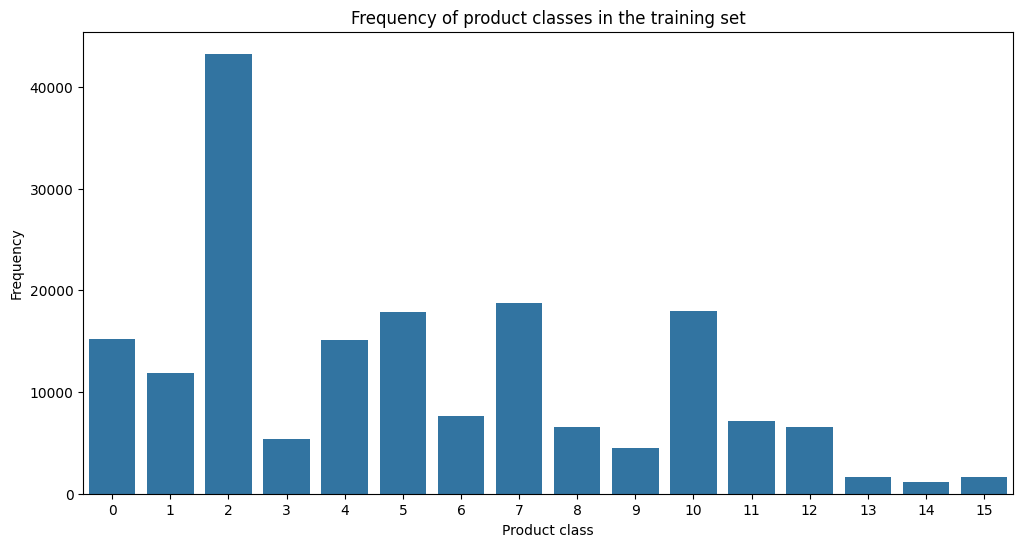

In [12]:
plt.figure(figsize=(12, 6))
# Plot the frequency of product classes in the training set
_ = sns.countplot(x=y_train).set(
    xlabel="Product class",
    ylabel="Frequency",
    title="Frequency of product classes in the training set",
)

In [13]:
# Create a dataframe for the training set
df_train = pd.DataFrame({'pid': pid_train, 'pid_categ': y_train})

# Create a dataframe for the testing set
df_test  = pd.DataFrame({'pid': pid_test})

In [14]:
# Create a column with product prices to the training and test set
df_train['pid_price'], df_test['pid_price'] = df_train['pid'].map(pid_price), df_test['pid'].map(pid_price)

# Create a column to indicate if the price is missing (NA) in the training and test set
df_train, df_test = [df.assign(price_na=df['pid_price'].isna().astype(int)) for df in (df_train, df_test)]

# Create a column with product descriptions to the training and test set
df_train['pid_desc'], df_test['pid_desc'] = df_train['pid'].map(pid_desc), df_test['pid'].map(pid_desc)

## Explore product descriptions

In [15]:
# Calculate the word count of product descriptions in the training set and test set
for df in [df_train, df_test]: df['pid_desc_word_count'] = df['pid_desc'].apply(lambda x: len(str(x).split()))

In [16]:
# Group word counts by product category in the training set
desc_90 = df_train[['pid_categ', 'pid_desc_word_count']].copy()
desc_90['word_90'] = desc_90.groupby('pid_categ')['pid_desc_word_count'].transform(lambda x: x.clip(upper=x.quantile(0.95)))

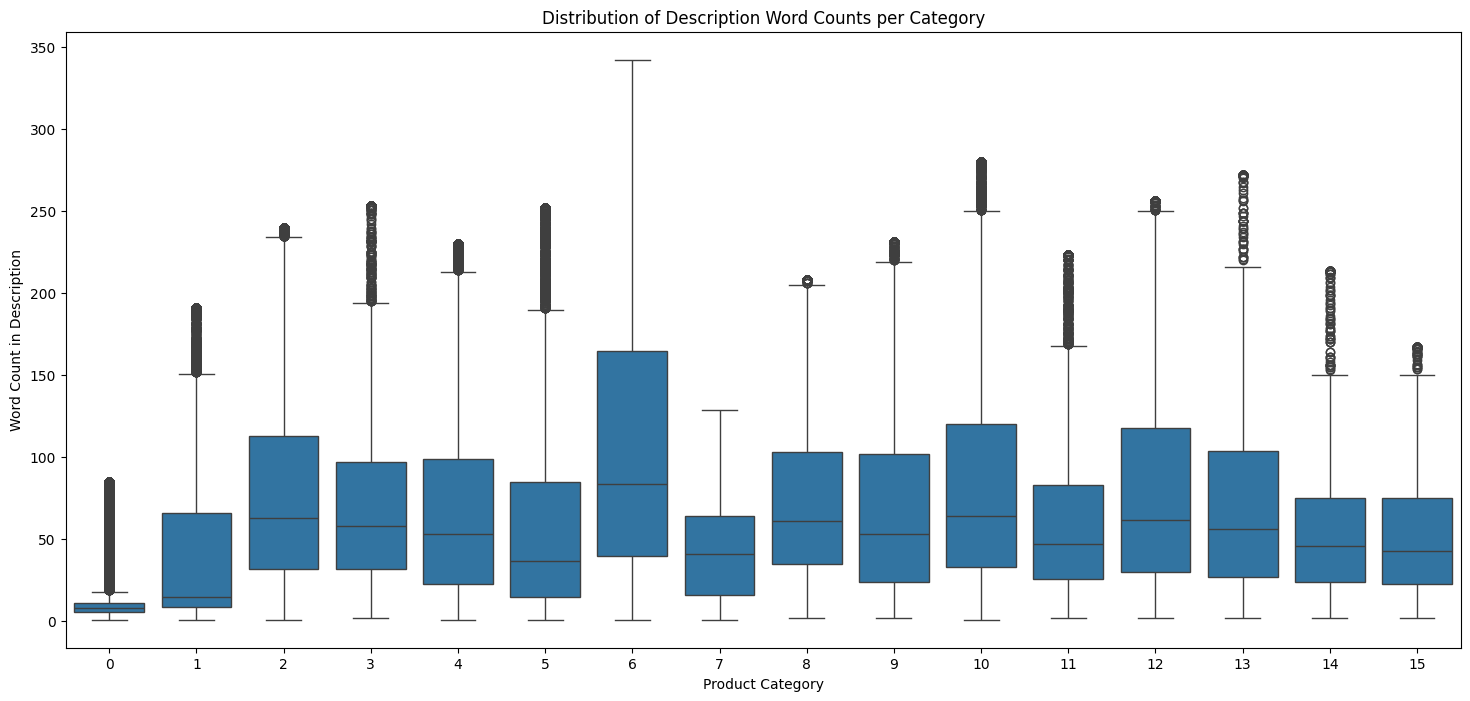

In [17]:
plt.figure(figsize=(18, 8))
# Plot boxplots for word counts in product descriptions in the training set
_ = sns.boxplot(
    x='pid_categ', 
    y='word_90', 
    data=desc_90
).set(
    xlabel="Product Category",
    ylabel="Word Count in Description",
    title="Distribution of Description Word Counts per Category"
)

## Explore product prices

In [18]:
na_prices_train = sum(pid not in pid_price for pid in pid_train)
print(f"A total of {na_prices_train} product IDs (out of {len(pid_train)}) in the training set have no price.")

A total of 46384 product IDs (out of 182006) in the training set have no price.


In [19]:
na_prices_test  = sum(pid not in pid_price for pid in pid_test)
print(f"A total of {na_prices_test} product IDs (out of {len(pid_test)}) in the test set have no price.")

A total of 11475 product IDs (out of 45502) in the test set have no price.


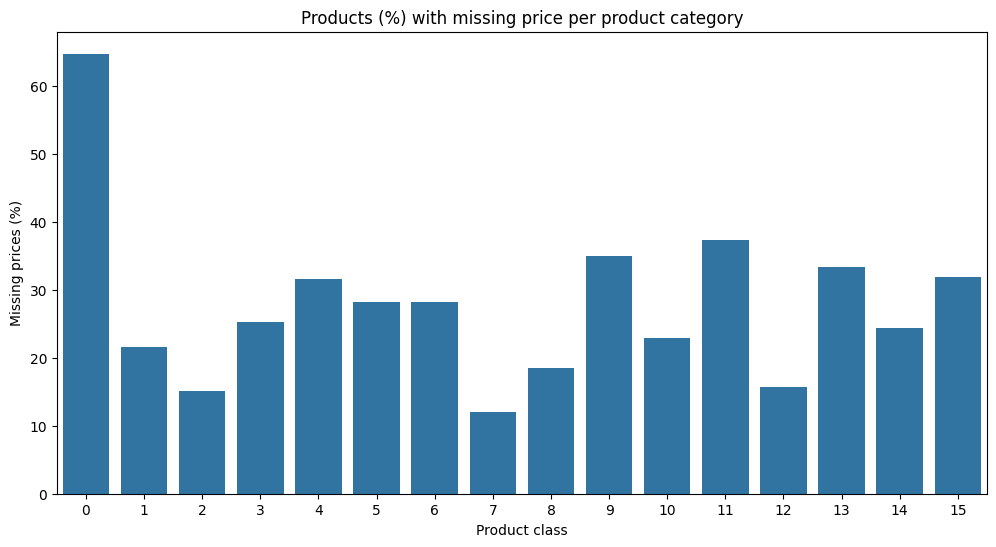

In [20]:
# Calculate the percentage of missing prices for each product category
na_c_price = 100 * df_train[df_train['pid_price'].isna()]['pid_categ'].value_counts() / df_train['pid_categ'].value_counts()

plt.figure(figsize=(12, 6))
_ = sns.barplot(x=na_c_price.index, y=na_c_price.values).set(
    xlabel="Product class",
    ylabel="Missing prices (%)",
    title="Products (%) with missing price per product category"
)

In [21]:
na_c_price.sort_values(ascending=False)

pid_categ
0     64.793933
11    37.366648
9     34.994463
13    33.333333
15    31.914894
4     31.620134
5     28.217933
6     28.163265
3     25.214312
14    24.357839
10    22.890425
1     21.659219
8     18.477435
12    15.685680
2     15.097087
7     11.972281
Name: count, dtype: float64

In [22]:
prices_90 = df_train.loc[df_train['pid_price'].notna(), ['pid_categ', 'pid_price']].copy()
prices_90['price_90'] = prices_90.groupby('pid_categ')['pid_price'].transform(lambda x: x.clip(upper=x.quantile(0.95)))

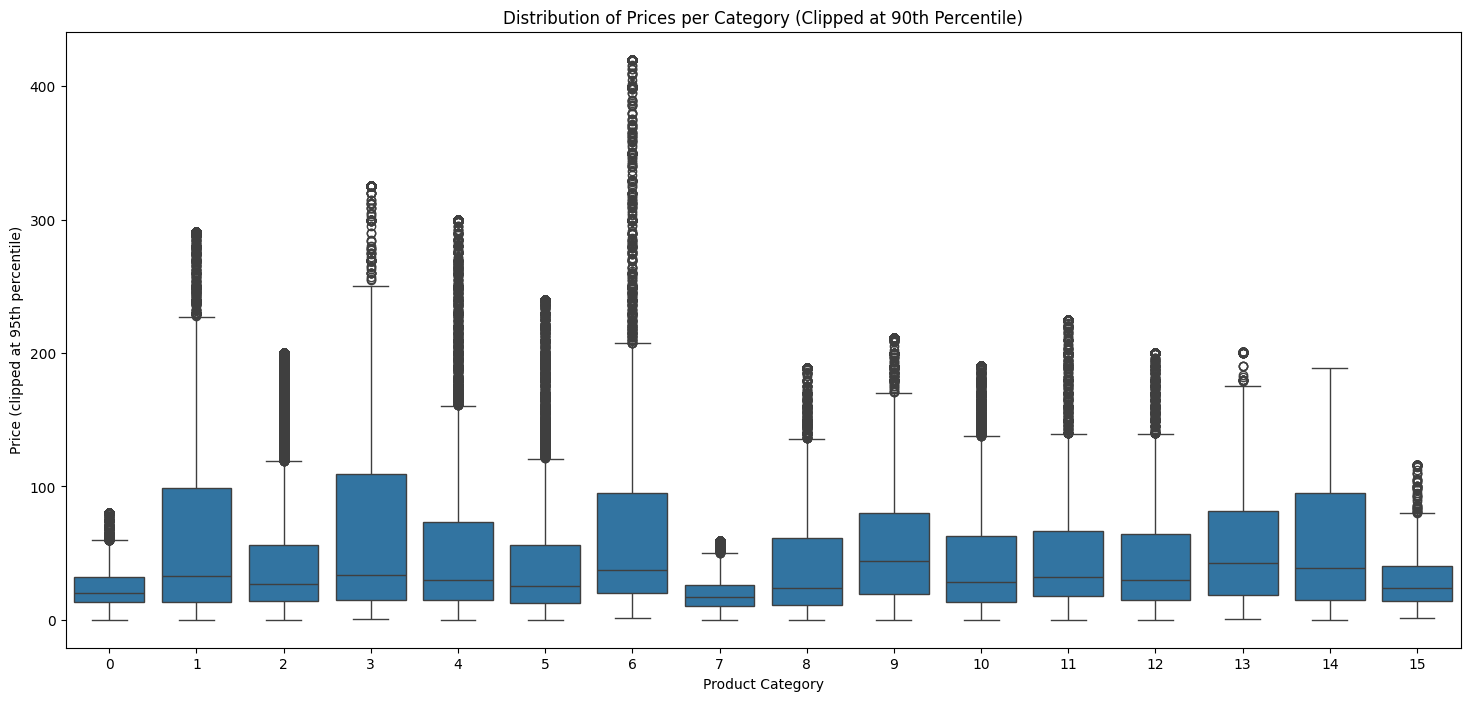

In [23]:
plt.figure(figsize=(18, 8))
# Plot boxplots with the distribution among classes of product prices in the training set
_ = sns.boxplot(
    x='pid_categ', 
    y='price_90', 
    data=prices_90
).set(
    xlabel="Product Category",
    ylabel="Price (clipped at 95th percentile)",
    title="Distribution of Prices per Category (Clipped at 90th Percentile)"
)

## Explore product graph

In [24]:
# Function to extract neighbors (connected product IDs) from the graph
def get_connected_products(pid, graph):
    return list(graph.neighbors(pid)) if graph.has_node(pid) else []

# Create a new column to store the connected product IDs in the training and test set 
for df in [df_train, df_test]: df['pid_graph'] = df['pid'].apply(lambda pid: get_connected_products(pid, G))

# Create a new column to count the number of connected products in the training and test set
for df in [df_train, df_test]: df['pid_graph_count'] = df['pid_graph'].apply(lambda x: len(x) if isinstance(x, list) else 0)

In [25]:
graph_90 = df_train[['pid_categ', 'pid_graph_count']].copy()
graph_90['pid_graph_count'] = graph_90.groupby('pid_categ')['pid_graph_count'].transform(lambda x: x.clip(upper=x.quantile(0.95)))

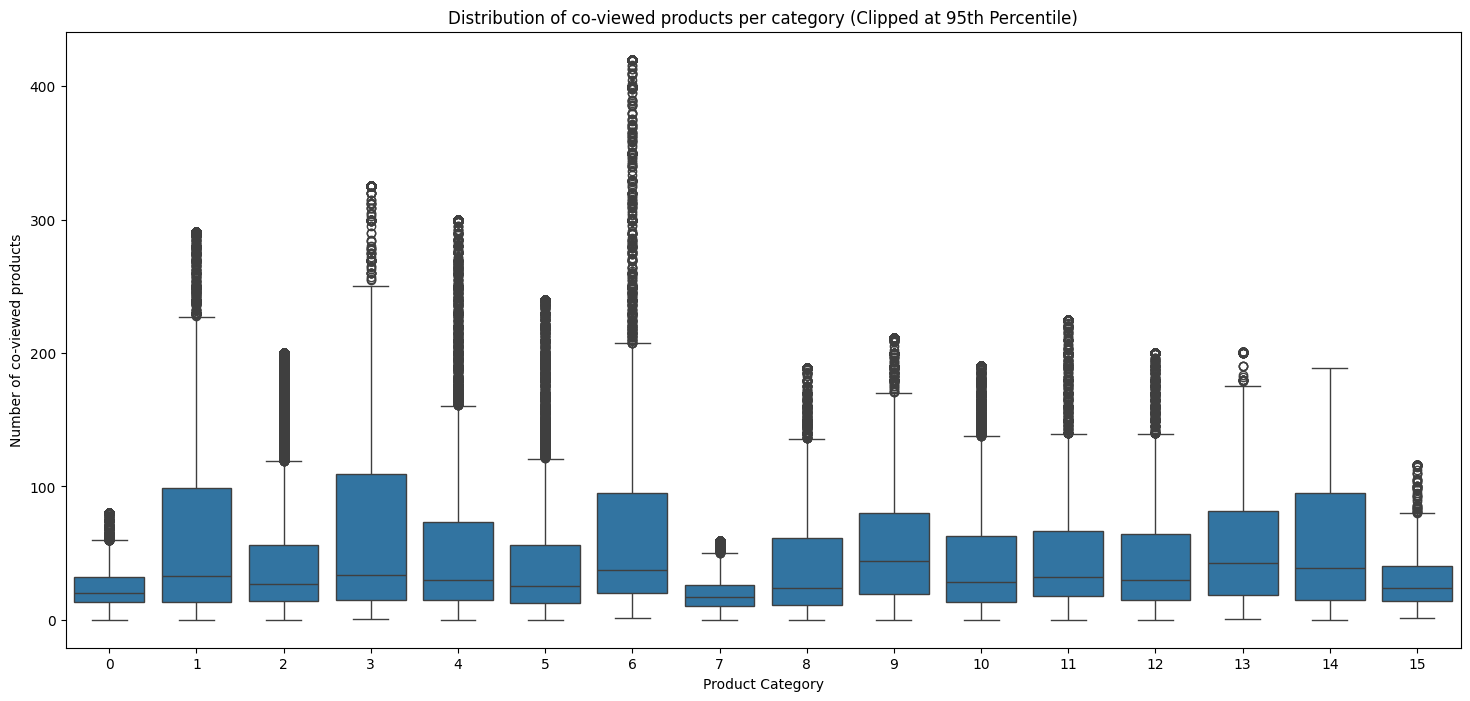

In [26]:
plt.figure(figsize=(18, 8))
_ = sns.boxplot(
    x='pid_categ', 
    y='price_90', 
    data=prices_90
).set(
    xlabel="Product Category",
    ylabel="Number of co-viewed products",
    title="Distribution of co-viewed products per category (Clipped at 95th Percentile)"
)

# Impute missing data

## Impute missing product prices

* Inputation strategy 1: Fill missing prices with the median of the co-viewed products in the graph.

In [ ]:
def impute_price_with_neighbors_median(row):
    if pd.notna(row['pid_price']):
        return row['pid_price']
    neighbor_prices = [pid_price[pid] for pid in row['pid_graph'] if pid in pid_price and pd.notna(pid_price[pid])]
    return np.median(neighbor_prices).round(2) if neighbor_prices else np.nan

# Impute missing prices in the training and test set using the median of the connected (co-viewed) product prices
df_train['pid_price'], df_test['pid_price'] = [df.apply(impute_price_with_neighbors_median, axis=1) for df in (df_train, df_test)]

* Inputation strategy 2: Fill missing prices with the mean price of the product neighbors based on TF-IDF.

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

vectorizer = TfidfVectorizer(
    max_features=10000,
    stop_words='english',
    min_df=5,
    max_df=0.9,
)

# Filter out rows with non-null prices for training and test sets
df_train_with_price  = df_train[df_train['pid_price'].notnull()]
df_train_miss_price  = df_train[df_train['pid_price'].isnull()]
df_test_miss_price   = df_test[df_test['pid_price'].isnull()]

# Vectorize product descriptions using TF-IDF
X_train_with_price = vectorizer.fit_transform(df_train_with_price['pid_desc'])

X_train_miss_price = vectorizer.transform(df_train_miss_price['pid_desc'])
X_test_miss_price  = vectorizer.transform(df_test_miss_price['pid_desc'])

# Fit NearestNeighbors using known train prices
nbrs = NearestNeighbors(n_neighbors=5, metric='cosine').fit(X_train_with_price)

# Impute missing prices for train
_, indices_train = nbrs.kneighbors(X_train_miss_price)
imputed_prices_train = [df_train_with_price.iloc[inds]['pid_price'].mean().round(2) for inds in indices_train]

# Impute missing prices for test
_, indices_test = nbrs.kneighbors(X_test_miss_price)
imputed_prices_test = [df_train_with_price.iloc[inds]['pid_price'].mean().round(2) for inds in indices_test]

for df, imputed in zip([df_train, df_test], [imputed_prices_train, imputed_prices_test]): df.loc[df['pid_price'].isnull(), 'pid_price'] = imputed

# Feature engineering

## Features from graph

In [ ]:
import community as community_louvain

# Compute the core number of each node
core_num = nx.core_number(G)
# Compute the clustering coefficients for each node
clustering = nx.clustering(G)
# Compute the average neighbor degree for each node
avg_neighbor_degree = nx.average_neighbor_degree(G)
# Compute the best partition using Louvain method for each node
partition = community_louvain.best_partition(G)
# Compute the pagerank for each node
pagerank = nx.pagerank(G)
# Compute the ego size for each node
ego_size = {node: G.degree(node) for node in G.nodes}

In [84]:
# Create new columns with the graph-based features for the training set 
df_train['core_number']        = df_train['pid'].map(core_num)
df_train['clustering']         = df_train['pid'].map(clustering)
df_train['avg_neighbor_degree']= df_train['pid'].map(avg_neighbor_degree)
df_train['community']          = df_train['pid'].map(partition)
df_train['pagerank']           = df_train['pid'].map(pagerank)
df_train['ego_size']           = df_train['pid'].map(ego_size)

# Create new columns with the graph-based features for the test set 
df_test['core_number']         = df_test['pid'].map(core_num)
df_test['clustering']          = df_test['pid'].map(clustering)
df_test['avg_neighbor_degree'] = df_test['pid'].map(avg_neighbor_degree)
df_test['community']           = df_test['pid'].map(partition)
df_test['pagerank']            = df_test['pid'].map(pagerank)
df_test['ego_size']            = df_train['pid'].map(ego_size)

## Features from product descriptions

In [31]:
# Create a copy of the original product description column for the TF-IDF
for df in [df_train, df_test]: df['pid_desc_tfidf'] = df['pid_desc'].copy()

# Convert product descriptions to lowercase
for df in [df_train, df_test]: df['pid_desc_tfidf'] = df['pid_desc_tfidf'].str.lower()

# Remove punctuation from the product descriptions
for df in [df_train, df_test]: df['pid_desc_tfidf'] = df['pid_desc_tfidf'].str.replace(r'[^\w\s]', '', regex=True)

# Remove digits from the product descriptions
for df in [df_train, df_test]: df['pid_desc_tfidf'] = df['pid_desc_tfidf'].str.replace(r'\d+', '', regex=True)

# Normalize whitespaces on produdct descriptions
for df in [df_train, df_test]: df['pid_desc_tfidf'] = df['pid_desc_tfidf'].str.replace(r'\s+', ' ', regex=True).str.strip()

# Remove words with 1-character and 2-character length 
for df in [df_train, df_test]: df['pid_desc_tfidf'] = df['pid_desc_tfidf'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 2]))

In [32]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Remove english stopwords from the product descriptions (ENGLISH_STOP_WORDS of sklearn)
for df in [df_train, df_test]: df['pid_desc_tfidf'] = df['pid_desc_tfidf'].apply(lambda x: ' '.join([word for word in x.split() if word not in ENGLISH_STOP_WORDS]))

In [33]:
import nltk
import spacy

nltk.download('wordnet')
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mountzou/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Lemmatize words of product descriptions (e.g., running -> run)
for df in [df_train, df_test]: df['pid_desc_tfidf'] = df['pid_desc_tfidf'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

In [35]:
# Remove pronouns, determiners, coordinating conjunctions, and subordinating conjunctions from product descriptions
def spacy_remove_specific_pos(text, remove_pos={'PRON', 'DET', 'CCONJ', 'SCONJ'}):
    doc = nlp(text)
    return ' '.join([token.text for token in doc if token.pos_ not in remove_pos])

for df in [df_train, df_test]: df['pid_desc_tfidf'] = df['pid_desc_tfidf'].astype(str).apply(lambda x: spacy_remove_specific_pos(x))

In [ ]:
from nltk.tokenize import word_tokenize

# Tokenize product descriptions using word_tokenize of NLTK
def text_tokenize(text):
    return word_tokenize(str(text).lower())

common_words_categ = []

for cat in df_train['pid_categ'].unique():
    texts = df_train.loc[df_train['pid_categ'] == cat, 'pid_desc_tfidf']
    tokens = (token for text in texts for token in text_tokenize(text))
    word_counts = Counter(tokens)
    common_words = {word for word, count in word_counts.items() if count > 60}
    common_words_categ.append(common_words)

all_common_words = set.intersection(*common_words_categ) if common_words_categ else set()
print("Words with frequency > 60 in all product categories:", sorted(all_common_words))

Words with frequency > 60 in every category: ['bag', 'best', 'black', 'color', 'come', 'comfort', 'design', 'designed', 'durable', 'easy', 'extra', 'feature', 'glove', 'great', 'grip', 'hand', 'head', 'help', 'high', 'inch', 'includes', 'large', 'length', 'line', 'make', 'material', 'need', 'new', 'nylon', 'offer', 'perfect', 'performance', 'product', 'quality', 'set', 'size', 'standard', 'time', 'use', 'used', 'weight']


In [46]:
# Remove common words (frequnecy > 60) from product descriptions
def remove_common_words(text, words_to_remove):
    tokens = text_tokenize(text)
    return ' '.join([token for token in tokens if token not in words_to_remove])

for df in [df_train, df_test]:df['pid_desc_tfidf'] = df['pid_desc_tfidf'].apply(lambda x: remove_common_words(x, all_common_words))

In [73]:
top_words_per_category = {}

for cat in df_train['pid_categ'].unique():
    texts = df_train.loc[df_train['pid_categ'] == cat, 'pid_desc_tfidf']
    tokens = []
    for text in texts:
        tokens.extend(str(text).lower().split())
    most_common_words = Counter(tokens).most_common(10)
    # Format as "word (count)" for readability
    top_words_per_category[cat] = [word for word, count in most_common_words]

df_top_words = pd.DataFrame.from_dict(top_words_per_category, orient='columns')
df_top_words.index += 1

df_top_words

,9,3,2,5,0,1,10,6,8,7,14,4,12,11,13,15
1,skate,golf,holster,bike,men,bottle,tent,workout,ball,team,racquet,water,airsoft,bat,helmet,horse
2,wheel,ball,knife,bicycle,short,watch,pack,yoga,table,logo,tennis,boat,gun,ball,ski,saddle
3,skateboard,club,gun,tire,womens,water,pocket,exercise,game,nfl,ball,fit,paintball,baseball,snow,leather
4,scooter,cart,fit,light,pant,men,knife,mat,dart,licensed,player,fin,rifle,player,lens,halter
5,bearing,distance,blade,wheel,sock,sport,water,fitness,disc,mlb,power,marine,pistol,sport,goggles,pad
6,deck,iron,steel,rear,sleeve,bike,handle,body,cue,officially,racket,strap,barrel,softball,fit,fit
7,roller,putter,handle,helmet,fabric,steel,steel,training,chip,cap,badminton,swim,tactical,basketball,snowboard,whip
8,speed,tee,belt,alloy,champion,stainless,camping,muscle,trampoline,ncaa,frame,kayak,magazine,net,goggle,bit
9,truck,driver,sight,road,athletic,rack,blade,bar,poker,flag,string,mask,metal,fit,strap,riding
10,complete,feel,tactical,brake,fit,display,strap,resistance,player,favorite,wilson,foot,spring,soccer,frame,strap


In [74]:
category_top_words = {cat: set(words) for cat, words in top_words_per_category.items()}

In [ ]:
# Create new columns 'cX' with the occurencies of TOP-10 most frequent words of each X product category
for cat in df_train['pid_categ'].unique():
    col_name = f'c{cat}'

    # Initialize columns with 0
    for df in [df_train, df_test]:df[col_name] = 0

    # Get the set of top words for this category
    cat_words = category_top_words[cat]

    # Count word occurrences for each row
    for df in [df_train, df_test]:
        df[col_name] = df['pid_desc_tfidf'].apply(
            lambda text: sum(word in cat_words for word in str(text).lower().split())
        )

## Features from product prices

In [85]:
# Create a new column with the log-transformed prices
for df in [df_train, df_test]: df['price_log'] = np.log1p(df['pid_price'])

In [86]:
# Create a new column with the price deciles i.e., dividing the prices into 10 equal groups
for df in [df_train, df_test]: df['price_decile'] = pd.qcut(df['pid_price'], q=10, labels=False) + 1

In [87]:
def price_ending_pattern(price):
    cents = int((price * 100) % 100)
    if cents == 99:
        return '99' # psychological_99
    elif cents == 95:
        return '95' # psychological_99
    elif cents == 0:
        return '00' # round dollar
    elif cents == 50:
        return '50' # round half dollar
    elif cents % 10 == 0:
        return 'X0' # round dime
    else:
        return 'XX'

# Create a new column with the price ending pattern (last 2 digits after decimal)
for df in [df_train, df_test]: df['price_ending'] = df['pid_price'].apply(price_ending_pattern)

In [88]:
def price_segments(price):
    if price < 1:
        return 'U1'  # under 1 dollar
    elif price < 10:
        return 'U10' # under 10 dollars
    elif price < 50: 
        return 'U50' # under 50 dollars
    elif price < 100:
        return 'U100' # under 100 dollars
    else:
        return 'O100' # over 100 dollars

# Create a new column with price segments based on price ranges (under 1, 1-10, 10-50, 50-100, over 100)
for df in [df_train, df_test]: df['price_segment'] = df['pid_price'].apply(price_segments)

In [89]:
ordered_price_segments = {'U1': 0, 'U10': 1, 'U50': 2, 'U100': 3, 'O100': 4}

for df in [df_train, df_test]: df['price_segment_encoded'] = df['price_segment'].map(ordered_price_segments)

In [90]:
all_price_endings = set(df_train['price_ending']).union(set(df_test['price_ending']))

for price_ending in all_price_endings:
    df_train[f'price_ending_{price_ending}'] = (df_train['price_ending'] == price_ending).astype(int)
    df_test[f'price_ending_{price_ending}']  = (df_test['price_ending']  == price_ending).astype(int)

# Export dataframes

In [91]:
for df, name in zip([df_train, df_test], ['df_train.csv', 'df_test.csv']): df.to_csv(name, index=False)